###  Trotterized Ising model for open line in 1D 
 Following from the Schrödinger equation, the time evolution of a system initially in the state $\vert\psi(0)\rangle$ takes the form:

$$
\vert \psi(t) \rangle = e^{-i H t} \vert \psi(0) \rangle \text{,}
$$

where $H$ is the time-independent Hamiltonian under which the system is submitted. We consider a Hamiltonian that can be written as a weighted sum of Pauli terms $H=\sum_j a_j H_j$, with $H_j$ representing a tensor product of Pauli terms acting on $n$ qubits. Thus, the sequence of gates that approximate a single evolution step is found under the assumption that the product of matrix exponentials is a good approximation for the sum of matrix exponentials:

$$
\vert \psi(t) \rangle \approx \left(\prod_j e^{-i a_j H_j t/r} \right)^r \vert\psi(0) \rangle \text{,}
$$

where $t/r$ is the time slice (evolution step) that we are choosing. As a result, a gate to be applied $r$ times is created. A smaller timestep leads to a more accurate approximation. However, this also leads to deeper circuits which, in practice, leads to more error accumulation, becoming a critical aspect especially on NISQ devices. For the purposes of this tutorial, all simulations are Statevector simulator, which doesn't include any shot or hardware noise.

We will follow paper by Jamadagni at al.: [arXiv:2401.13625v1](https://arxiv.org/html/2401.13625v1).
The Transverse Field Ising Model (TFIM) Hamiltonian for 1D  open chain of length N (without periodic boundary condition) is
$$
H_{TFIM} = -  \sum_{i=0}^{N-2} \sigma_z^i \sigma_z^{i+1} - g(t) \sum_{j=0}^{N-1} \sigma_x^i  \text{,}
$$
where $ g(t)= -t/\tau_Q $ and $\tau_Q$ being the rate of the rate of the quanch. Since $g(t)$ is time-dependent, we'll treat it as a constant for each small time step.

In [201]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.options.sampler_options import SamplerOptions
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from time import time
import numpy as np

In [202]:
N = 4  # Number of qubits
J = 1.0  # Interaction strength
tau_Q = 2.0  # Quench time
final_time = 7.0  # Total evolution time
num_timesteps = 5  # Number of time steps
dt = final_time / num_timesteps  # Time step size

# Initialize list for Hamiltonians at each time step
HL = []

for step in range(num_timesteps):
    t = step * dt +dt
    g_t = t / tau_Q
    print(len(HL),step,t,g_t)
    pauli_strings = []
    coefficients = []

    # Interaction terms for chain without periodic boundary
    for i in range(N-1):
        z_term = ['I'] * N
        z_term[i] = 'Z'
        z_term[(i + 1) % N] = 'Z'  # Periodic boundary conditions
        pauli_strings.append(''.join(z_term))
        coefficients.append(-J)

    # Transverse field terms
    for i in range(N):
        x_term = ['I'] * N
        x_term[i] = 'X'
        pauli_strings.append(''.join(x_term))
        coefficients.append(-g_t)

    H = SparsePauliOp.from_list(zip(pauli_strings, coefficients))
    HL.append(H)
# HL

0 0 1.4 0.7
1 1 2.8 1.4
2 2 4.199999999999999 2.0999999999999996
3 3 5.6 2.8
4 4 7.0 3.5


In [203]:
print('1st H-step:\n',HL[0])

1st H-step:
 SparsePauliOp(['ZZII', 'IZZI', 'IIZZ', 'XIII', 'IXII', 'IIXI', 'IIIX'],
              coeffs=[-1. +0.j, -1. +0.j, -1. +0.j, -0.7+0.j, -0.7+0.j, -0.7+0.j, -0.7+0.j])


The second-order formula, called the Suzuki-Trotter decomposition [3], and can be used in Qiskit by means of the [SuzukiTrotter class](https://docs.quantum.ibm.com/api/qiskit/qiskit.synthesis.SuzukiTrotter). Using this formula, a second order decomposition is:

$$
e^{A+B} \approx e^{B/2}e^{A}e^{B/2}
$$

By means of recursions, higher-order approximations can be found [1].

In [204]:
order_formula =SuzukiTrotter(order=2 ,reps=1,insert_barriers=True)  # reps:Number of repetitions per time step
trotter=PauliEvolutionGate(HL, dt, synthesis=order_formula)
qc = QuantumCircuit(H.num_qubits)
qc.x(3)
print(qc) # initial state

          
q_0: ─────
          
q_1: ─────
          
q_2: ─────
     ┌───┐
q_3: ┤ X ├
     └───┘


In [205]:
qc.append(trotter, range(N))
#qcD = qc.decompose()
#qcD.draw("mpl")  # mpl

job started,  nq=4  at aer_simulator ...
N=4  timesteps=5 depth=37  nonlocal_gates=27
Gate breakdown:RX: 36, RZZ: 27, BARRIER: 8, X: 1


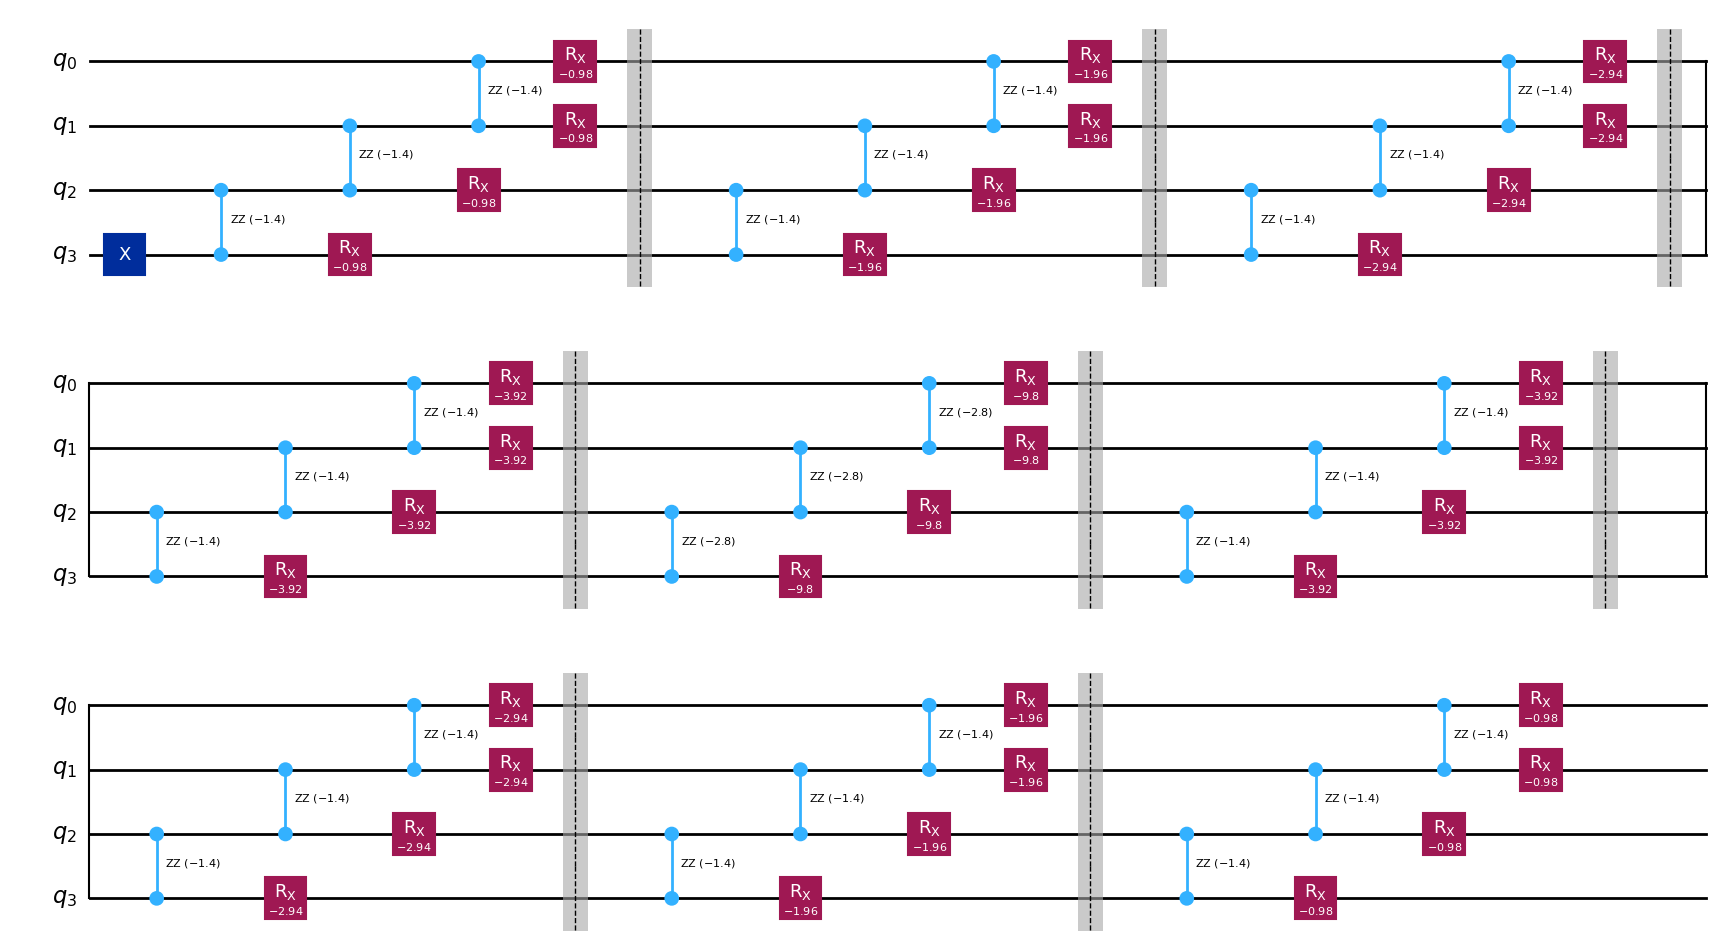

In [206]:
backend = AerSimulator()
print('job started,  nq=%d  at %s ...'%(qc.num_qubits,backend.name))
options = SamplerOptions()
options.default_shots=1000
estimator = Estimator(backend) #, options=options)

pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
qcT = pm.run(qc)
print('N=%d  timesteps=%d depth=%d  nonlocal_gates=%d\nGate breakdown:%s'%(N,num_timesteps,qcT.depth(),qcT.num_nonlocal_gates(),
                                                        ", ".join([f"{k.upper()}: {v}" for k, v in qcT.count_ops().items()])))

qcT.draw("mpl")  # mpl

In [207]:
magnetization_op = SparsePauliOp.from_sparse_list(
    [("Z", [i], 1.0) for i in range(0, N)], num_qubits=N)

observable = magnetization_op.apply_layout(qcT.layout)

In [208]:
job = estimator.run([(qcT, observable)])
result = job.result()
rdata=result[0].data
print("Expectation value: %.3f +/- %.3f "%(rdata.evs,rdata.stds))
print("Metadata: ",result[0].metadata)


Expectation value: 0.473 +/- 0.056 
Metadata:  {'target_precision': 0.015625, 'shots': 4096, 'circuit_metadata': {}}
